In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io, feature, filters, transform, measure
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.measure import find_contours
from scipy import ndimage as ndi
import pickle

from utils import *

In [2]:
def calculate_quantitative_metrics(nucleus_image, cc_labels):
    """
    计算细胞核图像的量化指标。
    
    参数:
    nucleus_image: numpy.ndarray, 细胞核图像，灰度图
    cc_mask: numpy.ndarray, 染色中心的掩膜，二值图
    
    返回:
    metrics: dict, 包含所有量化指标的字典
    """
    metrics = {}
    
    # 计算可见染色中心的数量
    num_cc = np.max(cc_labels)
    metrics['chromatin_num'] = num_cc
    
    # 计算细胞核面积
    nuclear_area = np.sum(nucleus_image > 0)
    metrics['nuclear_area'] = nuclear_area
    
    # 计算平均chromatin面积
    cc_areas = [np.sum(cc_labels == i) for i in range(1, num_cc + 1)]
    metrics['chromatin_area'] = np.mean(cc_areas)

#     # 计算相对(核)chromatin面积和 (RCA-S)
#     metrics['RCA-S'] = np.sum(cc_areas)/nuclear_area

#     # 计算相对(核)chromatin面积平均 (RCA-M)
#     metrics['RCA-M'] = np.mean(cc_areas)/nuclear_area
    
#     # 计算细胞核强度平均
#     nuclear_intensity = np.mean(nucleus_image[nucleus_image > 0])
#     metrics['nuclear_intensity'] = nuclear_intensity

#     # 计算平均chromatin强度平均 (CI-M)
#     cc_intensities = [np.mean(nucleus_image[cc_labels == i]) for i in range(1, num_cc + 1)]
#     metrics['chromatin_intensity'] = np.mean(cc_intensities)

#     # 计算相对(核)chromatin强度和 (RCI-S)
#     metrics['RCI-S'] = np.sum(cc_intensities)/nuclear_intensity

#     # 计算相对(核)chromatin强度平均 (RCI-M)
#     metrics['RCI-M'] = np.mean(cc_intensities)/nuclear_intensity
    
#     # 计算相对(核)chromatin比例 (RHF)
#     rhf = hf * rhi
#     metrics['relative_heterochromatin_fraction'] = rhf

    # Axis ratio
    metrics['axis_ratio'] = Axis_ratio_nucleus(cc_labels)
    return metrics

def Axis_ratio(image):
    # 计算区域属性
    regions = measure.regionprops(image)

    # 计算长轴和短轴的比
    if len(regions)==1: 
        region = regions[0]
        if region.area >= 1:  # 过滤掉面积过小的区域
            if region.minor_axis_length > 0:  # 避免除以零
                axis_ratio = region.major_axis_length / region.minor_axis_length
                return axis_ratio
            else: return None
#                 print("minor_axis_length is 0, return None")
                
    else: return None
#         print("Find more than one particle in mask, return None")

def Axis_ratio_nucleus(cc_mask):
    all_cc_mask = [cc_mask==i for i in range(1, cc_mask.max())]
    all_cc_mask = np.array(all_cc_mask).astype(int)
    print(all_cc_mask.shape)

    all_Axis_ratio=[]
    for mask in all_cc_mask:
        ratio = Axis_ratio(mask)
        if ratio!=None: all_Axis_ratio.append(ratio)

    return np.mean(all_Axis_ratio)

💠 CTRL-HPS9999-H3K27ac Calculate_quantitative_metrics:
chromatin_num: 134
nuclear_area: 42887
chromatin_area: 30.619402985074625
RCA-S: 0.09567001655513326
RCA-M: 0.0007139553474263676
nuclear_intensity: 25.88537319001096
chromatin_intensity: 34.56388589694757
RCI-S: 178.9257846967519
RCI-M: 1.3352670499757602
axis_ratio: 1.7412006868242467


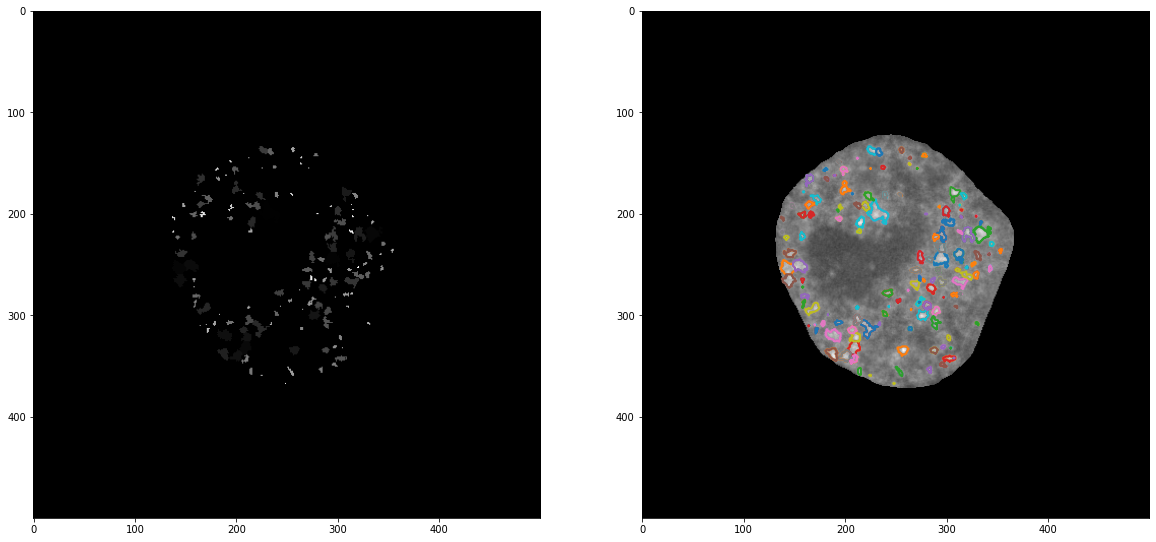

💠 CTRL-HPS9999-CTCF Calculate_quantitative_metrics:
chromatin_num: 171
nuclear_area: 42887
chromatin_area: 15.859649122807017
RCA-S: 0.06323594562454823
RCA-M: 0.0003698008516055452
nuclear_intensity: 50.895189684519785
chromatin_intensity: 75.8799639595279
RCI-S: 254.94499416367975
RCI-M: 1.4909063986180102
axis_ratio: 1.6121821469351778


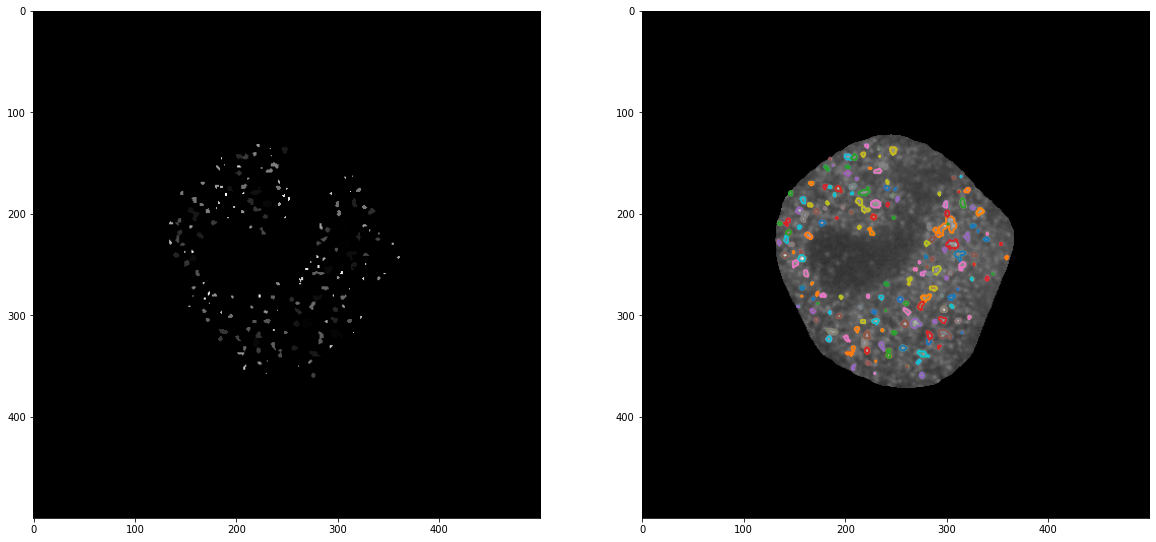

In [3]:
num = 1
home_path = "../Classification"
rett_type = "HPS9999"

ctrl_type = "CTRL"

H3K27ac_labels = show_mask_and_metrics(ctrl_type, rett_type, "H3K27ac", num)
CTCF_labels = show_mask_and_metrics(ctrl_type, rett_type, "CTCF", num)

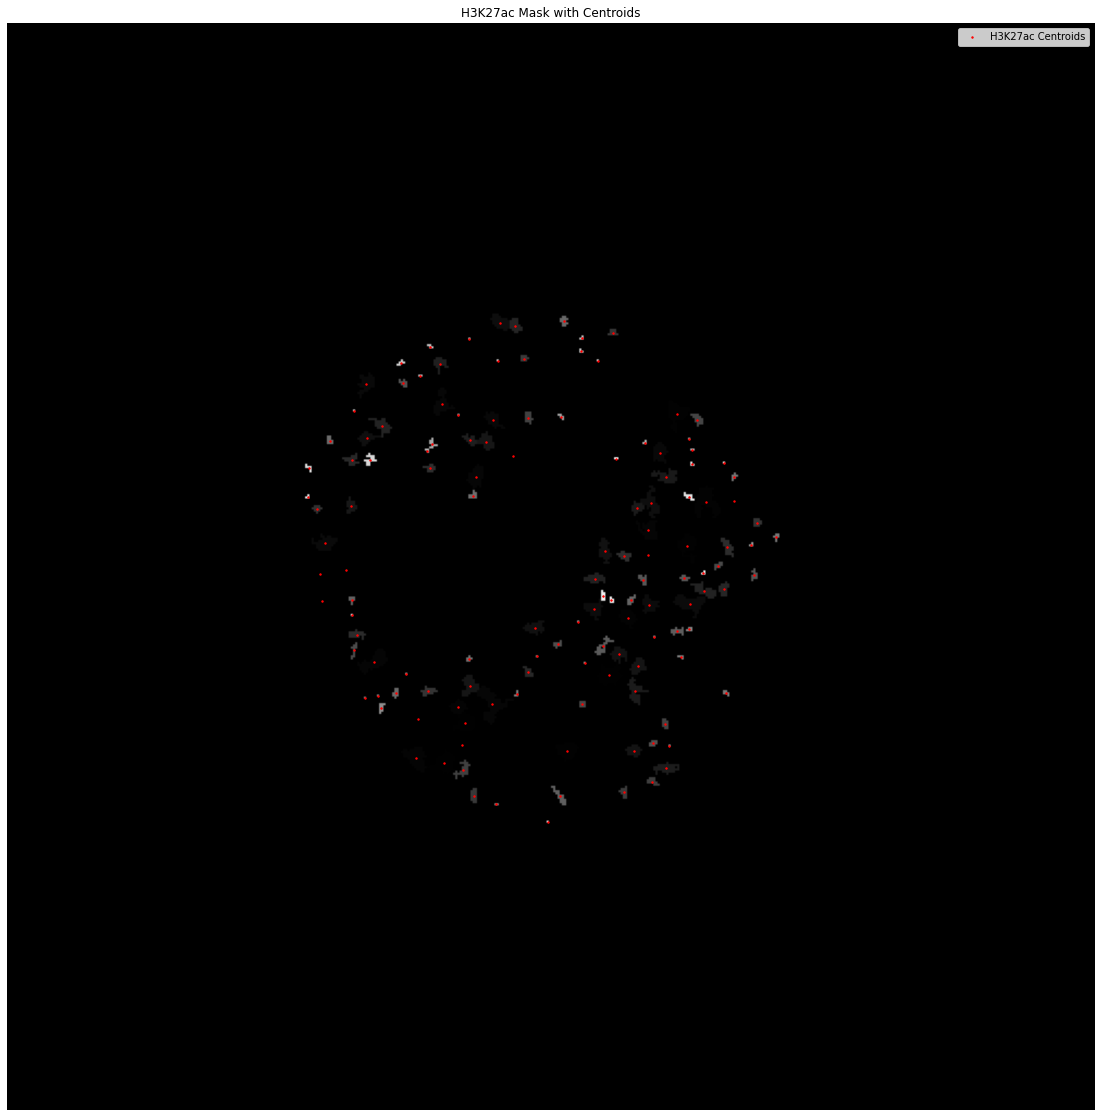

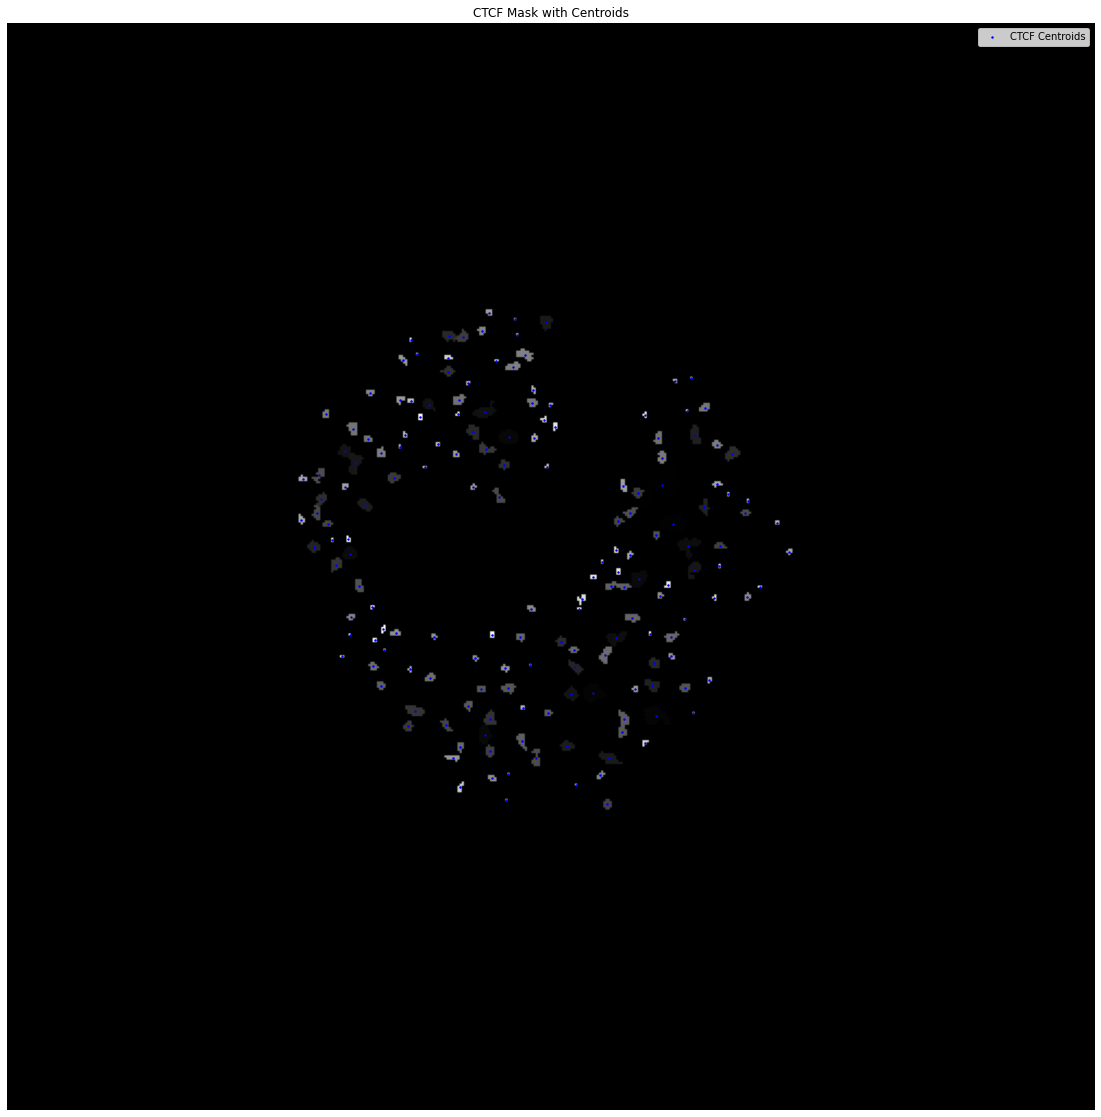

In [4]:
H3K27ac_props = measure.regionprops(H3K27ac_labels)
CTCF_props = measure.regionprops(CTCF_labels)

H3K27ac_centroids = np.array([prop.centroid for prop in H3K27ac_props])
CTCF_centroids = np.array([prop.centroid for prop in CTCF_props])

# 绘制H3K27ac掩膜和质点
plt.figure(figsize=(20, 20))
plt.imshow(H3K27ac_labels*(H3K27ac_labels), cmap='gray')
plt.scatter(H3K27ac_centroids[:, 1], H3K27ac_centroids[:, 0], color='red', s=2, label='H3K27ac Centroids')
plt.title('H3K27ac Mask with Centroids')
plt.legend()
plt.axis('off')
plt.show()

# 绘制CTCF掩膜和质点
plt.figure(figsize=(20, 20))
plt.imshow(CTCF_labels, cmap='gray')
plt.scatter(CTCF_centroids[:, 1], CTCF_centroids[:, 0], color='blue', s=2, label='CTCF Centroids')
plt.title('CTCF Mask with Centroids')
plt.legend()
plt.axis('off')
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.spatial import distance

def H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels):
    # 获取连通组件的质心
    H3K27ac_props = measure.regionprops(H3K27ac_labels)
    CTCF_props = measure.regionprops(CTCF_labels)

    H3K27ac_centroids = np.array([prop.centroid for prop in H3K27ac_props])
    CTCF_centroids = np.array([prop.centroid for prop in CTCF_props])

    # 计算每个H3K27ac粒子到最近的CTCF粒子的距离
    nearest_distances = []
    for h3_centroid in H3K27ac_centroids:
        distances = distance.cdist([h3_centroid], CTCF_centroids, 'euclidean')
        nearest_distance = np.min(distances)
        nearest_distances.append(nearest_distance)
    
    return nearest_distances

def H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels, maxradii=50):
    # 获取连通组件的质心
    H3K27ac_props = measure.regionprops(H3K27ac_labels)
    CTCF_props = measure.regionprops(CTCF_labels)

    H3K27ac_centroids = np.array([prop.centroid for prop in H3K27ac_props])
    CTCF_centroids = np.array([prop.centroid for prop in CTCF_props])

    # 设置要计算的不同半径范围
    radii = np.arange(0, maxradii, 1)  # 0到50像素，步长为5

    # 计算每个H3K27ac粒子不同半径范围内的CTCF粒子数量
    counts_per_radius = {radius: [] for radius in radii}

    for h3_centroid in H3K27ac_centroids:
        distances = distance.cdist([h3_centroid], CTCF_centroids, 'euclidean')[0]
        for radius in radii:
            count_within_radius = np.sum(distances <= radius)
            counts_per_radius[radius].append(count_within_radius)

    # 计算每个半径范围内的平均CTCF粒子数量
    average_counts_per_radius = {radius: np.mean(counts) for radius, counts in counts_per_radius.items()}
    
    return average_counts_per_radius 

💠 CTRL-HPS9999-H3K27ac Calculate_quantitative_metrics:
chromatin_num: 134
nuclear_area: 42887
chromatin_area: 30.619402985074625
RCA-S: 0.09567001655513326
RCA-M: 0.0007139553474263676
nuclear_intensity: 25.88537319001096
chromatin_intensity: 34.56388589694757
RCI-S: 178.9257846967519
RCI-M: 1.3352670499757602
axis_ratio: 1.7412006868242467


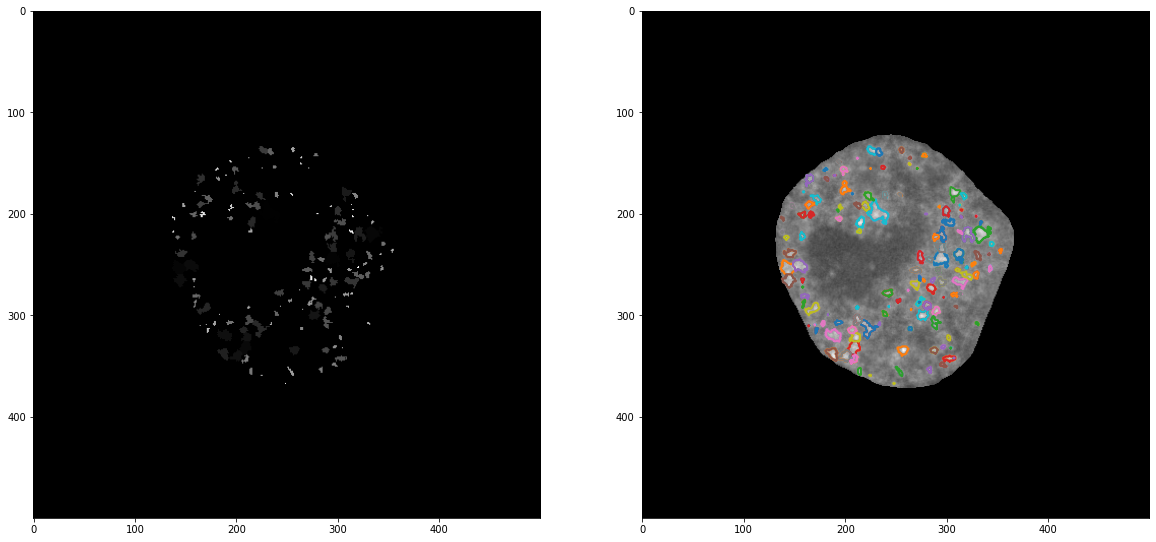

💠 CTRL-HPS9999-CTCF Calculate_quantitative_metrics:
chromatin_num: 171
nuclear_area: 42887
chromatin_area: 15.859649122807017
RCA-S: 0.06323594562454823
RCA-M: 0.0003698008516055452
nuclear_intensity: 50.895189684519785
chromatin_intensity: 75.8799639595279
RCI-S: 254.94499416367975
RCI-M: 1.4909063986180102
axis_ratio: 1.6121821469351778


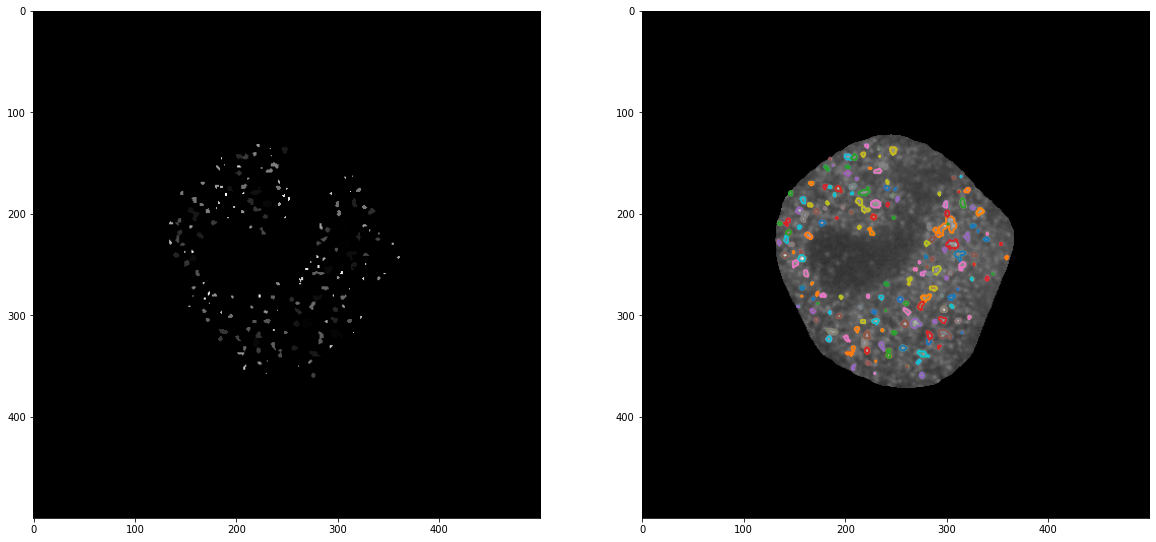

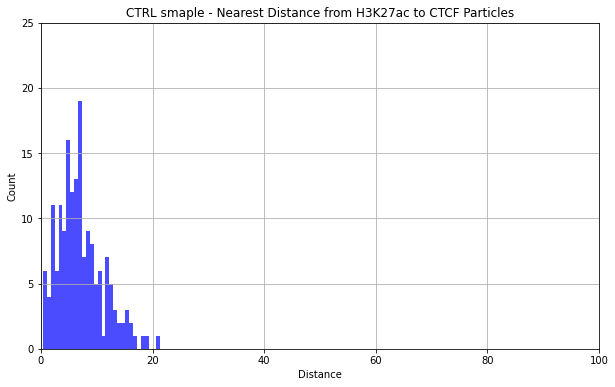

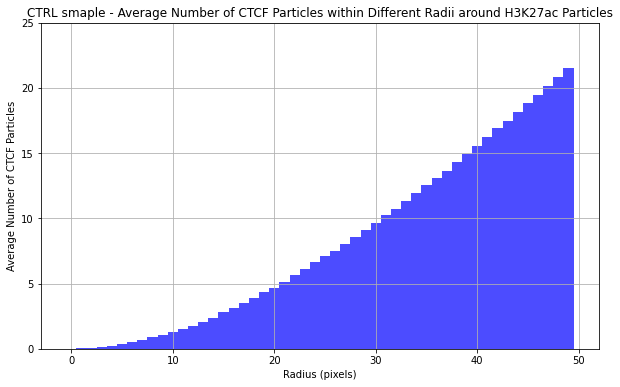

In [6]:
ctrl_type = "CTRL"

H3K27ac_labels = show_mask_and_metrics(ctrl_type, rett_type, "H3K27ac", num)
CTCF_labels = show_mask_and_metrics(ctrl_type, rett_type, "CTCF", num)

# nearest_distances = H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels)
nearest_distances = H3K27ac_centroids_ctcf_mindist(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.hist(nearest_distances, bins=30, color='blue', alpha=0.7)
plt.title('CTRL smaple - Nearest Distance from H3K27ac to CTCF Particles')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.xlim(0,100)
plt.ylim(0,25)
plt.grid(True)
plt.show()
    
# average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels)
average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.bar(average_counts_per_radius.keys(), average_counts_per_radius.values(), width=1, color='blue', alpha=0.7)
plt.title('CTRL smaple - Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,25)
plt.grid(True)
plt.show()

In [7]:
print(f"💠 nearest_distances {len(nearest_distances)} \n", nearest_distances)

print("💠 average_counts_per_radius\n", average_counts_per_radius)

💠 nearest_distances 171 
 [4.1330058108637, 11.908122756083952, 7.1871677187423, 5.614383185629193, 8.96843060505781, 10.46895254601223, 2.039930540478597, 7.501707862235457, 0.34775421644768445, 7.1083873665804695, 5.502163575571481, 6.044703442867909, 5.205970657520885, 6.905597515865636, 4.747315122051168, 2.022234220920225, 8.19213376725245, 11.750820186534499, 2.077380952380963, 6.383961041029964, 3.2796425663968223, 8.24425071894138, 2.382928822118056, 5.401268641576311, 4.667589250779095, 7.609066565021604, 3.9797779182642863, 9.367859947714848, 2.0672851327451744, 5.663472605768966, 4.767553713529257, 5.573668957265491, 5.151598628261522, 6.933176169031306, 5.1245492284943674, 3.971886320202453, 3.484625607742128, 5.758436701837118, 13.665041146596028, 6.9614052773059605, 3.2092969287461606, 12.951956258816104, 9.33482130996028, 3.5691295471013964, 8.709320181949726, 8.438091543049842, 10.641869561082844, 1.9919235202580319, 6.941813560605326, 11.831288187061022, 14.67305298343

💠 RETT-HPS9999-H3K27ac Calculate_quantitative_metrics:
chromatin_num: 139
nuclear_area: 55378
chromatin_area: 15.007194244604317
RCA-S: 0.0376683881685868
RCA-M: 0.00027099559833515687
nuclear_intensity: 19.228213369930298
chromatin_intensity: 31.258550034012778
RCI-S: 225.9668317142003
RCI-M: 1.6256606598143908
axis_ratio: 1.6687501366334672


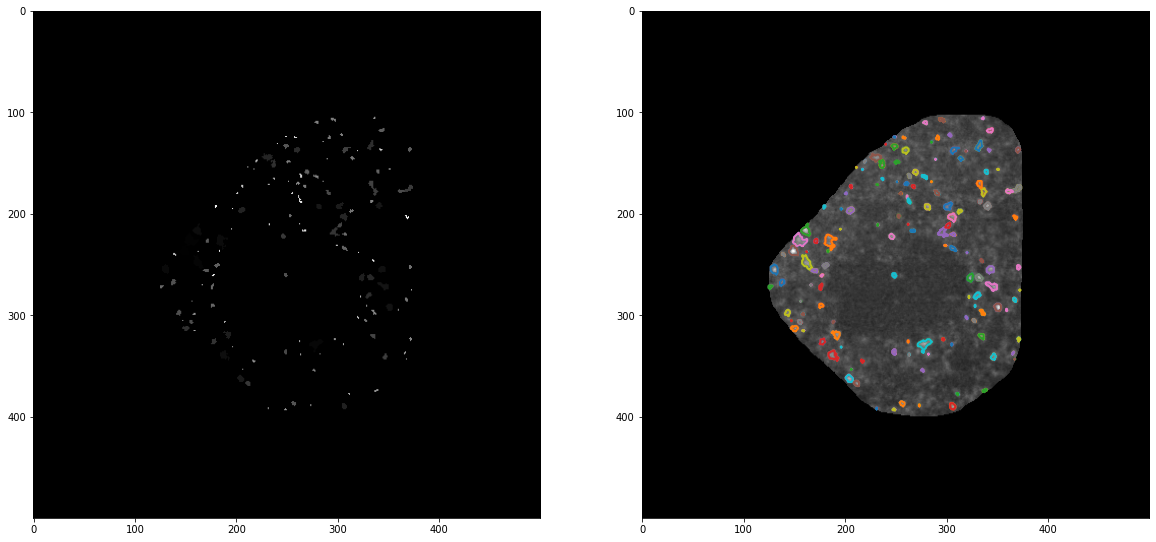

💠 RETT-HPS9999-CTCF Calculate_quantitative_metrics:
chromatin_num: 167
nuclear_area: 55378
chromatin_area: 11.131736526946108
RCA-S: 0.03356928744266676
RCA-M: 0.00020101369726147764
nuclear_intensity: 50.50763841236592
chromatin_intensity: 88.28878606352329
RCI-S: 291.9207418139455
RCI-M: 1.7480283940954822
axis_ratio: 1.6215991061025883


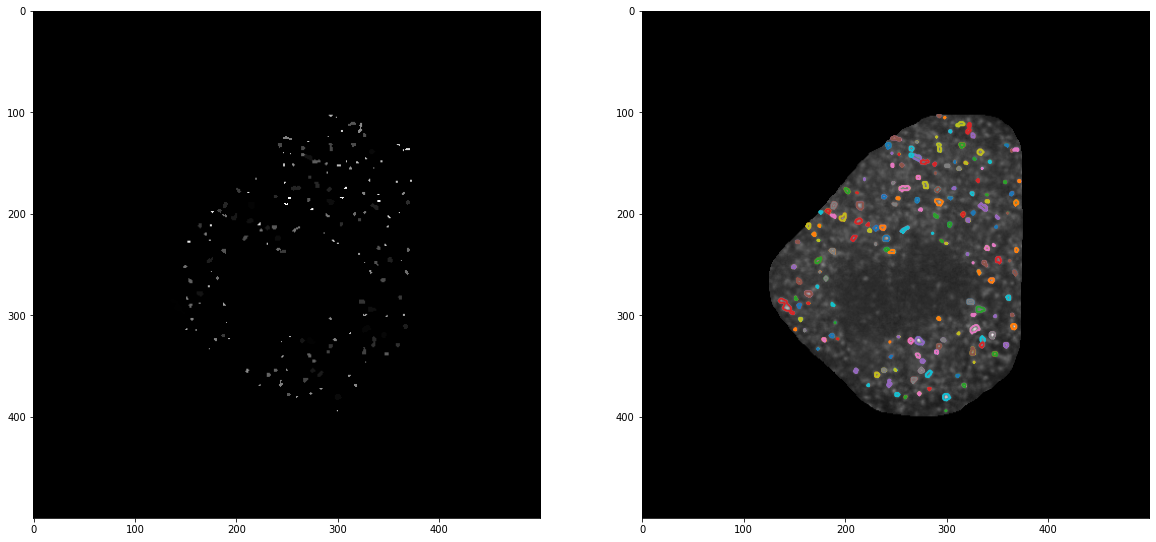

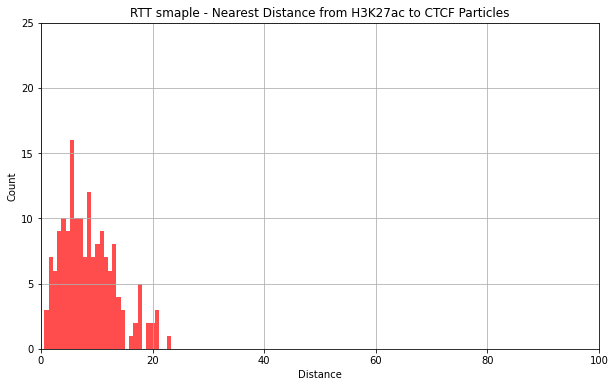

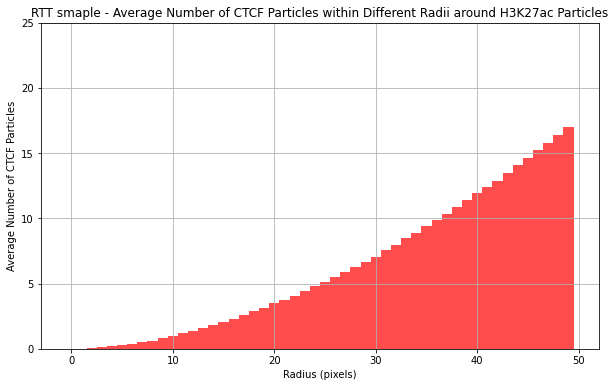

In [8]:
ctrl_type = "RETT"

H3K27ac_labels = show_mask_and_metrics(ctrl_type, rett_type, "H3K27ac", num)
CTCF_labels = show_mask_and_metrics(ctrl_type, rett_type, "CTCF", num)

# nearest_distances = H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels)
nearest_distances = H3K27ac_centroids_ctcf_mindist(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.hist(nearest_distances, bins=30, color='red', alpha=0.7)
plt.title('RTT smaple - Nearest Distance from H3K27ac to CTCF Particles')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.xlim(0,100)
plt.ylim(0,25)
plt.grid(True)
plt.show()
    
# average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels)
average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.bar(average_counts_per_radius.keys(), average_counts_per_radius.values(), width=1, color='red', alpha=0.7)
plt.title('RTT smaple - Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,25)
plt.grid(True)
plt.show()

In [9]:
print(f"💠 nearest_distances {len(nearest_distances)} \n", nearest_distances)

print("💠 average_counts_per_radius\n", average_counts_per_radius)

💠 nearest_distances 167 
 [6.829660097080906, 6.083175689320306, 10.653880976133852, 8.286573283715603, 10.578904001669693, 6.199123573112385, 11.05108196060459, 5.762610869712921, 9.419468854181643, 3.6163990396372303, 13.384067595385693, 13.733696927506637, 8.927220523331375, 2.6938671858918375, 1.2870144715580984, 8.735410577596427, 7.078217079518909, 3.773364712030895, 13.459017536998203, 8.703604482644268, 12.30513894716643, 4.262758626888377, 3.2288978382723723, 5.097297910428067, 8.030777281366417, 6.802777210652835, 3.4269267807313573, 13.743725841270257, 13.141103913761576, 1.821747214413458, 8.629099490948697, 10.416823128076658, 8.026207074328438, 5.893225246520655, 5.2528235273471715, 5.369023992616991, 6.48268061290959, 4.661466867457196, 14.903091251227442, 2.924228293261506, 5.712680826216538, 11.834254804458915, 17.50273527196543, 8.246211251235321, 12.7285234274041, 9.446396378347792, 6.064990650200686, 3.0013018008857424, 5.794238432270122, 7.020616960068396, 16.00973

# Extract All

In [ ]:
if ctrl_type=="RETT":
    image_path = f"{ctrl_type}_{rett_type}_{chip_type}"
elif ctrl_type=="CTRL":
    image_path = f"{ctrl_type}_{chip_type}"

## H3K27ac to CTCF

In [49]:
home_path = "../Classification"

# CTRL
nearest_distances_ctrl = []
average_counts_per_radius_ctrl = []

H3K27ac_image = np.load(f"{home_path}/Datasets/CTRL_H3K27ac.npy", allow_pickle=True)[:,:,:,0]
CTCF_image = np.load(f"{home_path}/Datasets/CTRL_CTCF.npy", allow_pickle=True)[:,:,:,0]

for num in tqdm(range(len(H3K27ac_image))):

    H3K27ac_labels = thre_h_watershed(H3K27ac_image[num], min_distance=5, max_area=1000)
    CTCF_labels = thre_h_watershed(CTCF_image[num], min_distance=5, max_area=1000)

#     nearest_distances = H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels)
#     nearest_distances_ctrl.append(nearest_distances)

    average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels, maxradii=100)
    average_counts_per_radius_ctrl.append(average_counts_per_radius)

100%|██████████████████████████████████████████████████████| 1723/1723 [03:55<00:00,  7.32it/s]


In [50]:
# RETT
nearest_distances_rett = []
average_counts_per_radius_rett = []

H3K27ac_image = np.load(f"{home_path}/Datasets/RETT_HPS9999_H3K27ac.npy", allow_pickle=True)[:,:,:,0]
CTCF_image = np.load(f"{home_path}/Datasets/RETT_HPS9999_CTCF.npy", allow_pickle=True)[:,:,:,0]

for num in tqdm(range(len(H3K27ac_image))):

    H3K27ac_labels = thre_h_watershed(H3K27ac_image[num], min_distance=5, max_area=1000)
    CTCF_labels = thre_h_watershed(CTCF_image[num], min_distance=5, max_area=1000)

#     nearest_distances = H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels)
#     nearest_distances_rett.append(nearest_distances)
    
    average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels, maxradii=100)
    average_counts_per_radius_rett.append(average_counts_per_radius)

100%|██████████████████████████████████████████████████████| 3595/3595 [07:37<00:00,  7.85it/s]


In [51]:
# 保存为 .pkl 文件
# with open('h3k27ac2ctcf_nearest_distances_rett.pkl', 'wb') as f:
#     pickle.dump(nearest_distances_rett, f)
    
# with open('h3k27ac2ctcf_nearest_distances_ctrl.pkl', 'wb') as f:
#     pickle.dump(nearest_distances_ctrl, f)

# with open('h3k27ac2ctcf_average_counts_per_radius_rett-100.pkl', 'wb') as f:
#     pickle.dump(average_counts_per_radius_rett, f)
    
# with open('h3k27ac2ctcf_average_counts_per_radius_ctrl-100.pkl', 'wb') as f:
#     pickle.dump(average_counts_per_radius_ctrl, f)

# CTCF to H3K27ac

In [106]:
home_path = "../Classification"

# CTRL
nearest_distances_ctrl = []
average_counts_per_radius_ctrl = []

H3K27ac_image = np.load(f"{home_path}/Datasets/CTRL_H3K27ac.npy", allow_pickle=True)[:,:,:,0]
CTCF_image = np.load(f"{home_path}/Datasets/CTRL_CTCF.npy", allow_pickle=True)[:,:,:,0]

for num in tqdm(range(len(H3K27ac_image))):

    H3K27ac_labels = thre_h_watershed(H3K27ac_image[num], min_distance=5, max_area=1000)
    CTCF_labels = thre_h_watershed(CTCF_image[num], min_distance=5, max_area=1000)

#     nearest_distances = H3K27ac_centroids_ctcf_mindist(CTCF_labels, H3K27ac_labels)
#     nearest_distances_ctrl.append(nearest_distances)
    
    average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(CTCF_labels, H3K27ac_labels, maxradii=25)
    average_counts_per_radius_ctrl.append(average_counts_per_radius)

100%|██████████████████████████████████████████████████████| 1723/1723 [02:41<00:00, 10.69it/s]


In [107]:
# RETT
nearest_distances_rett = []
average_counts_per_radius_rett = []

H3K27ac_image = np.load(f"{home_path}/Datasets/RETT_HPS9999_H3K27ac.npy", allow_pickle=True)[:,:,:,0]
CTCF_image = np.load(f"{home_path}/Datasets/RETT_HPS9999_CTCF.npy", allow_pickle=True)[:,:,:,0]

for num in tqdm(range(len(H3K27ac_image))):

    H3K27ac_labels = thre_h_watershed(H3K27ac_image[num], min_distance=5, max_area=1000)
    CTCF_labels = thre_h_watershed(CTCF_image[num], min_distance=5, max_area=1000)

#     nearest_distances = H3K27ac_centroids_ctcf_mindist(CTCF_labels, H3K27ac_labels)
#     nearest_distances_rett.append(nearest_distances)
    
    average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(CTCF_labels, H3K27ac_labels, maxradii=25)
    average_counts_per_radius_rett.append(average_counts_per_radius)

100%|██████████████████████████████████████████████████████| 3595/3595 [05:24<00:00, 11.08it/s]


In [108]:
# 保存为 .pkl 文件
# with open('ctcf2h3k27ac_nearest_distances_rett.pkl', 'wb') as f:
#     pickle.dump(nearest_distances_rett, f)
    
# with open('ctcf2h3k27ac_nearest_distances_ctrl.pkl', 'wb') as f:
#     pickle.dump(nearest_distances_ctrl, f)

# with open('ctcf2h3k27ac_average_counts_per_radius_rett.pkl', 'wb') as f:
#     pickle.dump(average_counts_per_radius_rett, f)
    
# with open('ctcf2h3k27ac_average_counts_per_radius_ctrl.pkl', 'wb') as f:
#     pickle.dump(average_counts_per_radius_ctrl, f)

# Analyze feature

In [38]:
with open('ctcf2h3k27ac_nearest_distances_rett.pkl', 'rb') as f:
    nearest_distances_rett = pickle.load(f)

with open('ctcf2h3k27ac_nearest_distances_ctrl.pkl', 'rb') as f:
    nearest_distances_ctrl = pickle.load(f)
    
with open('ctcf2h3k27ac_average_counts_per_radius_rett.pkl', 'rb') as f:
    average_counts_per_radius_rett = pickle.load(f)
    
with open('ctcf2h3k27ac_average_counts_per_radius_ctrl.pkl', 'rb') as f:
    average_counts_per_radius_ctrl = pickle.load(f)
    
# with open('h3k27ac2ctcf_nearest_distances_rett.pkl', 'rb') as f:
#     nearest_distances_rett = pickle.load(f)

# with open('h3k27ac2ctcf_nearest_distances_ctrl.pkl', 'rb') as f:
#     nearest_distances_ctrl = pickle.load(f)
    
# with open('h3k27ac2ctcf_average_counts_per_radius_rett.pkl', 'rb') as f:
#     average_counts_per_radius_rett = pickle.load(f)
    
# with open('h3k27ac2ctcf_average_counts_per_radius_ctrl.pkl', 'rb') as f:
#     average_counts_per_radius_ctrl = pickle.load(f)

## nearest_distances_ctrl

In [39]:
import itertools
merged_nearest_distances_ctrl = list(itertools.chain(*nearest_distances_ctrl))
merged_nearest_distances_rett = list(itertools.chain(*nearest_distances_rett))
print(f"merged_nearest_distances_ctrl: {len(merged_nearest_distances_ctrl)}")
print(f"merged_nearest_distances_rett: {len(merged_nearest_distances_rett)}")

merged_nearest_distances_ctrl: 242714
merged_nearest_distances_rett: 459537


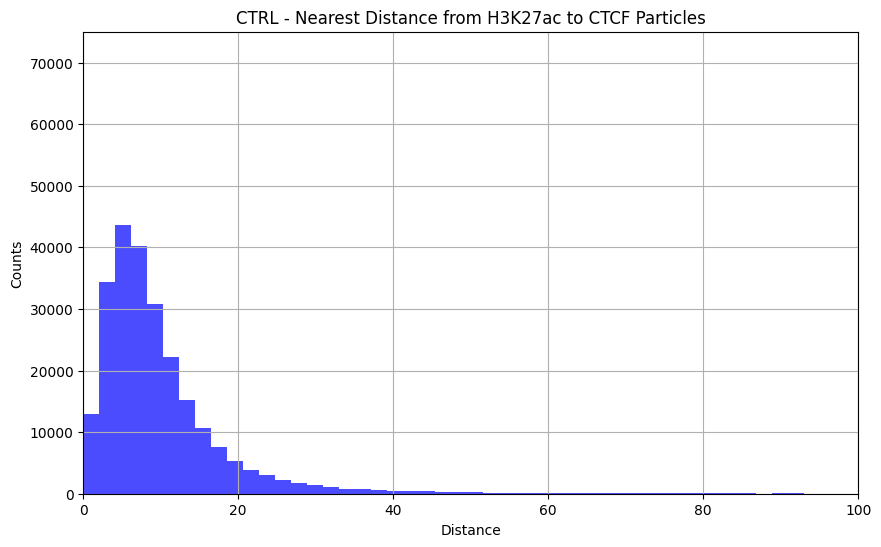

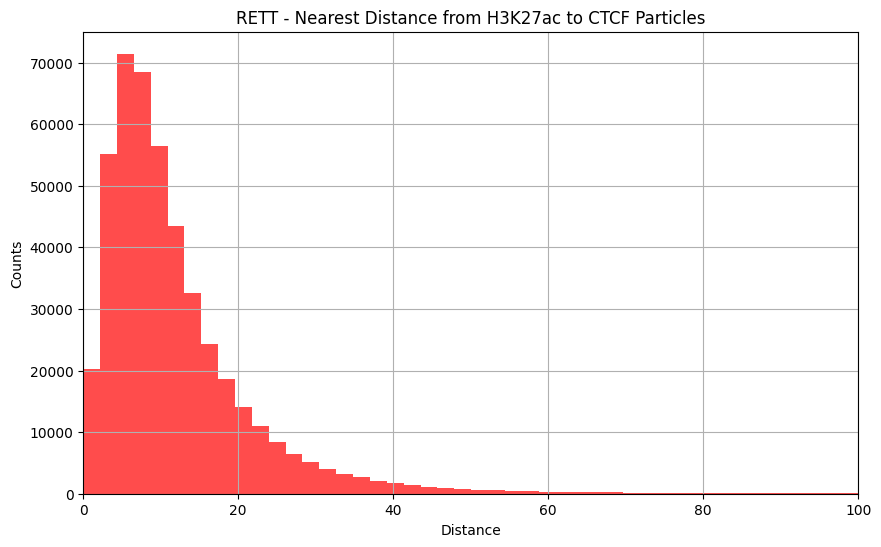

In [43]:
ylim = 75000
title = ["CTRL", "RETT"]
color = ["blue", "red"]
merged_nearest_distances = [merged_nearest_distances_ctrl, merged_nearest_distances_rett]
for i in range(2):
    # 绘制最近距离的直方图
    plt.figure(figsize=(10, 6))
    plt.hist(merged_nearest_distances[i], bins=100, density=False, alpha=0.7, color=color[i])
#     plt.title(f'{title[i]} - Nearest Distance from CTCF to H3K27ac Particles')
    plt.title(f'{title[i]} - Nearest Distance from H3K27ac to CTCF Particles')
    plt.xlabel('Distance')
    plt.ylabel('Counts')
    plt.xlim(0, 100)
    plt.ylim(0, ylim)
    plt.grid(True)
    plt.show()
    
#     plt.figure(figsize=(10, 6))
#     counts, bin_edges = np.histogram(merged_nearest_distances[i], bins=100)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], color=color[i], alpha=0.7, edgecolor='black')
# #     plt.title(f'{title[i]} - Nearest Distance from CTCF to H3K27ac Particles')
#     plt.title(f'{title[i]} - Nearest Distance from H3K27ac to CTCF Particles')
#     plt.xlabel('Distance')
#     plt.ylabel('Counts')
#     plt.xlim(0, 100)
#     plt.ylim(0, ylim)
#     plt.grid(True)
#     plt.show()

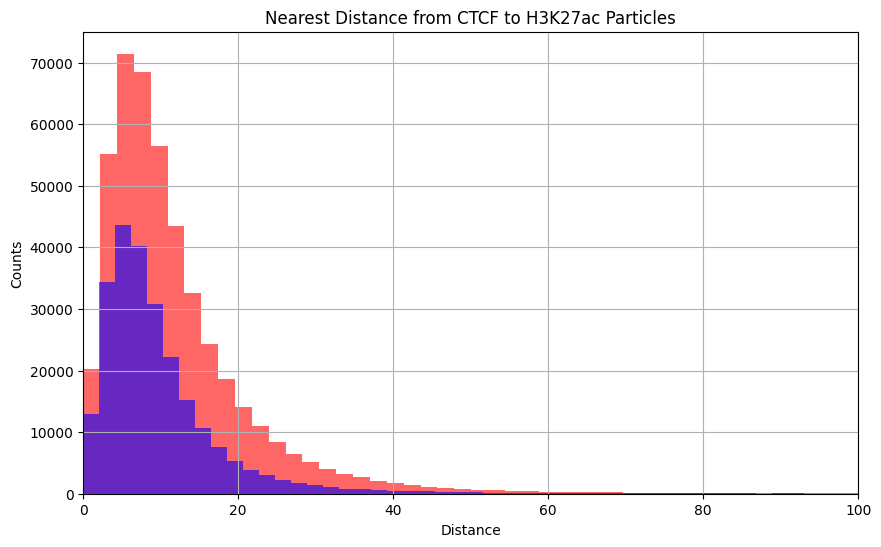

In [45]:
# 绘制最近距离的直方图
plt.figure(figsize=(10, 6))
plt.hist(merged_nearest_distances_rett, bins=100, density=False, alpha=0.6, color='red')
plt.hist(merged_nearest_distances_ctrl, bins=100, density=False, alpha=0.6, color='blue')

# plt.title('Nearest Distance from H3K27ac to CTCF Particles')
plt.title('Nearest Distance from CTCF to H3K27ac Particles')

plt.xlabel('Distance')
plt.ylabel('Counts')
plt.xlim(0, 100)
plt.ylim(0, ylim)
plt.grid(True)
plt.show()

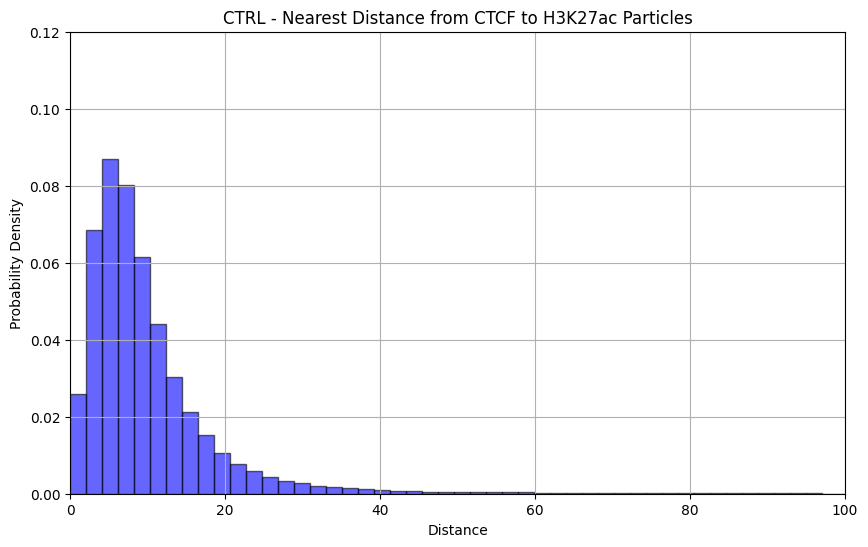

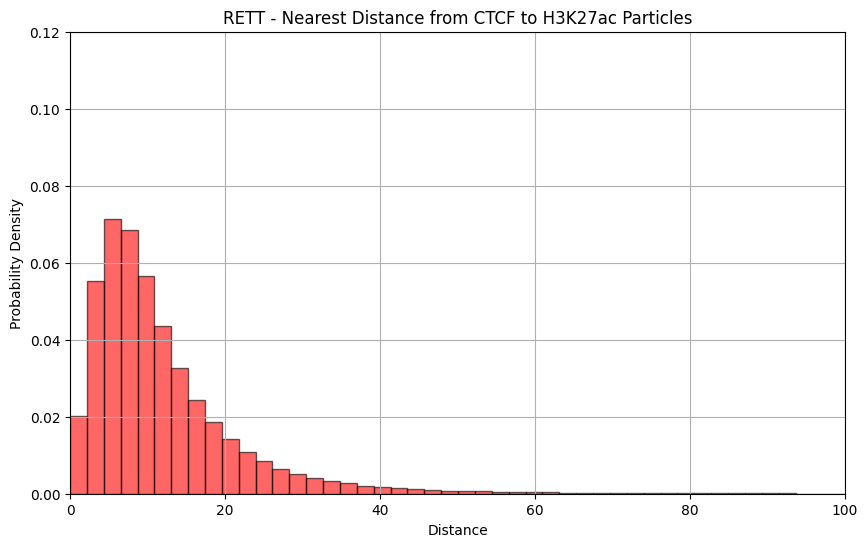

In [47]:
ylim = 0.12
title = ["CTRL", "RETT"]
color = ["blue", "red"]
merged_nearest_distances = [merged_nearest_distances_ctrl, merged_nearest_distances_rett]
for i in range(2):
    # 绘制最近距离的直方图
    plt.figure(figsize=(10, 6))
    plt.hist(merged_nearest_distances[i], bins=100, density=True, alpha=0.6, color=color[i], edgecolor='black')
    # plt.title(f'{title[i]} - Nearest Distance from H3K27ac to CTCF Particles')
    plt.title(f'{title[i]} - Nearest Distance from CTCF to H3K27ac Particles')
    plt.xlabel('Distance')
    plt.ylabel('Probability Density')
    plt.xlim(0, 100)
    plt.ylim(0, ylim)
    plt.grid(True)
    plt.show()
    
#     plt.figure(figsize=(10, 6))
#     counts, bin_edges = np.histogram(merged_nearest_distances[i], bins=100)
#     possibility = counts / sum(counts)

#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     print(sum(possibility))
#     print(bin_centers)

#     plt.bar(bin_centers, possibility, color=color[i], alpha=0.7, edgecolor='black')
#     plt.title(f'{title[i]} - Nearest Distance from H3K27ac to CTCF Particles')
# #     plt.title(f'{title[i]} - Nearest Distance from CTCF to H3K27ac Particles')
#     plt.xlabel('Distance')
#     plt.ylabel('Probability Density')
#     plt.xlim(0, 100)
#     plt.ylim(0, ylim)
#     plt.grid(True)
#     plt.show()

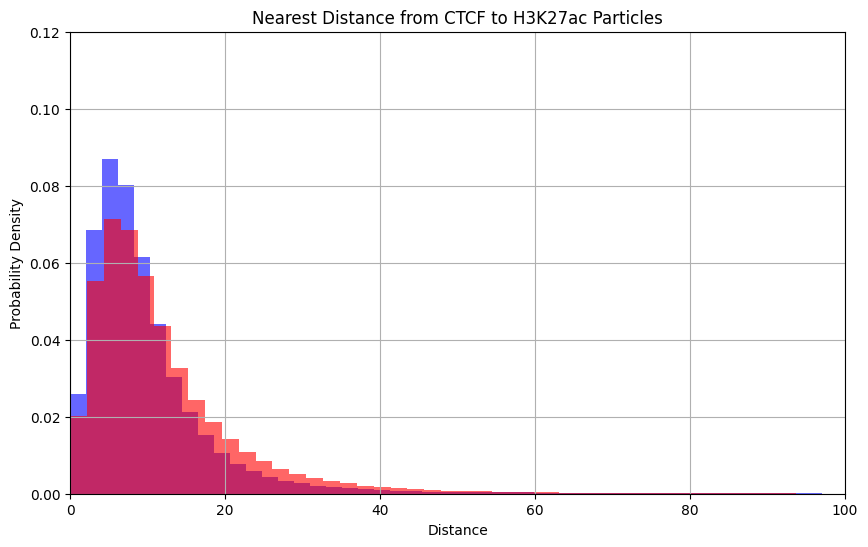

In [49]:
# 绘制最近距离的直方图
plt.figure(figsize=(10, 6))
plt.hist(merged_nearest_distances_ctrl, bins=100, density=True, alpha=0.6, color='blue')
plt.hist(merged_nearest_distances_rett, bins=100, density=True, alpha=0.6, color='red')
# plt.title('Nearest Distance from H3K27ac to CTCF Particles')
plt.title('Nearest Distance from CTCF to H3K27ac Particles')
plt.xlabel('Distance')
plt.ylabel('Probability Density')
plt.xlim(0, 100)
plt.ylim(0, ylim)
plt.grid(True)
plt.show()


# plt.figure(figsize=(10, 6))
# for i in range(2):
#     counts, bin_edges = np.histogram(merged_nearest_distances[i], bins=100)
#     possibility = counts / sum(counts)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     plt.bar(bin_centers, possibility, width=bin_edges[1] - bin_edges[0], color=color[i], alpha=0.6)
# plt.title('Nearest Distance from H3K27ac to CTCF Particles')
# # plt.title('Nearest Distance from CTCF to H3K27ac Particles')
# plt.xlabel('Distance')
# plt.ylabel('Probability Density')
# plt.xlim(0, 100)
# plt.ylim(0, ylim)
# plt.grid(True)
# plt.show()

## average_counts_per_radius_rett

In [40]:
# ctcf2h3k27ac
with open('ctcf2h3k27ac_average_counts_per_radius_rett.pkl', 'rb') as f:
    average_counts_per_radius_rett = pickle.load(f)
    
with open('ctcf2h3k27ac_average_counts_per_radius_ctrl.pkl', 'rb') as f:
    average_counts_per_radius_ctrl = pickle.load(f)
    
# h3k27ac2ctcf
# with open('h3k27ac2ctcf_average_counts_per_radius_rett.pkl', 'rb') as f:
#     average_counts_per_radius_rett = pickle.load(f)
    
# with open('h3k27ac2ctcf_average_counts_per_radius_ctrl.pkl', 'rb') as f:
#     average_counts_per_radius_ctrl = pickle.load(f)

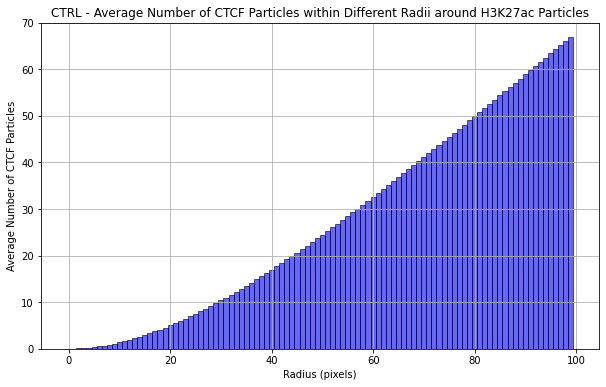

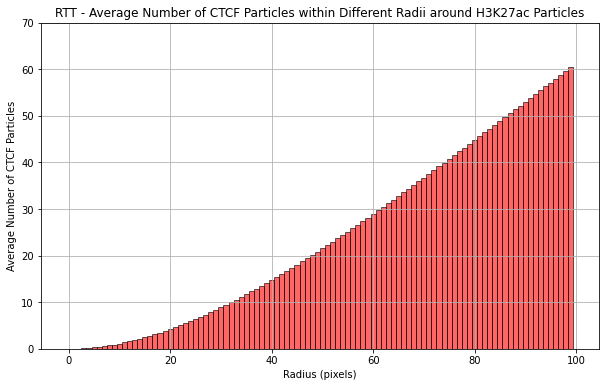

In [63]:
maxradii=100
ylim = 70
merge_average_counts_per_radius_rett = {radius: 0 for radius in range(maxradii)}
merge_average_counts_per_radius_ctrl = {radius: 0 for radius in range(maxradii)}

for i in range(maxradii):
    for rett in average_counts_per_radius_rett:
        merge_average_counts_per_radius_rett[i] += rett[i]
    merge_average_counts_per_radius_rett[i]/=len(average_counts_per_radius_rett)

    for ctrl in average_counts_per_radius_ctrl:
        merge_average_counts_per_radius_ctrl[i] += ctrl[i]
    merge_average_counts_per_radius_ctrl[i]/=len(average_counts_per_radius_ctrl)

plt.figure(figsize=(10, 6))
plt.bar(merge_average_counts_per_radius_ctrl.keys(), merge_average_counts_per_radius_ctrl.values(), width=1, color='blue', alpha=0.6, edgecolor='black')
plt.title('CTRL - Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
# plt.title('CTRL - Average Number of H3K27ac Particles within Different Radii around CTCF Particles')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,ylim)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(merge_average_counts_per_radius_rett.keys(), merge_average_counts_per_radius_rett.values(), width=1, color='red', alpha=0.6, edgecolor='black')
plt.title('RTT - Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
# plt.title('RTT - Average Number of H3K27ac Particles within Different Radii around CTCF Particles')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,ylim)
plt.grid(True)
plt.show()

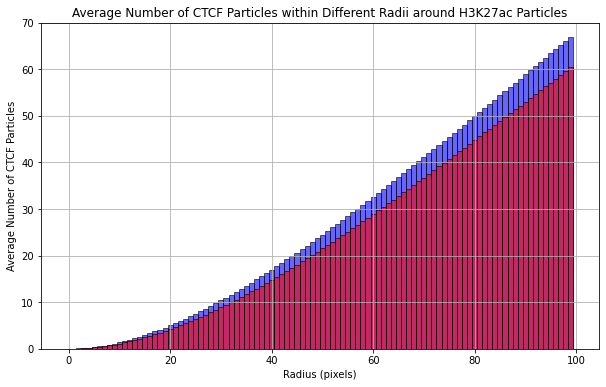

In [64]:
plt.figure(figsize=(10, 6))
plt.bar(merge_average_counts_per_radius_ctrl.keys(), merge_average_counts_per_radius_ctrl.values(), width=1, color='blue', alpha=0.6, edgecolor='black')
plt.bar(merge_average_counts_per_radius_rett.keys(), merge_average_counts_per_radius_rett.values(), width=1, color='red', alpha=0.6, edgecolor='black')

plt.title('Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
# plt.title('Average Number of H3K27ac Particles within Different Radii around CTCF Particles')

plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,ylim)
plt.grid(True)
plt.show()

# DEBUG

In [26]:
# with open('ctcf2h3k27ac_nearest_distances_rett.pkl', 'rb') as f:
#     nearest_distances_rett = pickle.load(f)

# with open('ctcf2h3k27ac_nearest_distances_ctrl.pkl', 'rb') as f:
#     nearest_distances_ctrl = pickle.load(f)
    
# with open('ctcf2h3k27ac_average_counts_per_radius_rett.pkl', 'rb') as f:
#     average_counts_per_radius_rett = pickle.load(f)
    
# with open('ctcf2h3k27ac_average_counts_per_radius_ctrl.pkl', 'rb') as f:
#     average_counts_per_radius_ctrl = pickle.load(f)
    
with open('h3k27ac2ctcf_nearest_distances_rett.pkl', 'rb') as f:
    nearest_distances_rett = pickle.load(f)

with open('h3k27ac2ctcf_nearest_distances_ctrl.pkl', 'rb') as f:
    nearest_distances_ctrl = pickle.load(f)
    
with open('h3k27ac2ctcf_average_counts_per_radius_rett.pkl', 'rb') as f:
    average_counts_per_radius_rett = pickle.load(f)
    
with open('h3k27ac2ctcf_average_counts_per_radius_ctrl.pkl', 'rb') as f:
    average_counts_per_radius_ctrl = pickle.load(f)

In [27]:
import itertools
merged_nearest_distances_ctrl = list(itertools.chain(*nearest_distances_ctrl))
merged_nearest_distances_rett = list(itertools.chain(*nearest_distances_rett))
print(f"merged_nearest_distances_ctrl: {len(merged_nearest_distances_ctrl)}")
print(f"merged_nearest_distances_rett: {len(merged_nearest_distances_rett)}")

merged_nearest_distances_ctrl: 185198
merged_nearest_distances_rett: 335673


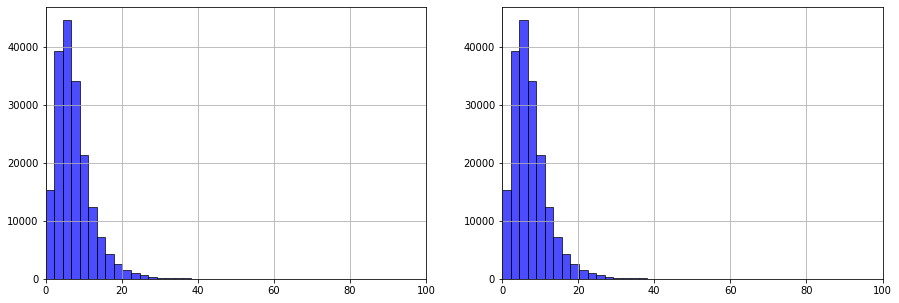

<Figure size 1080x360 with 0 Axes>

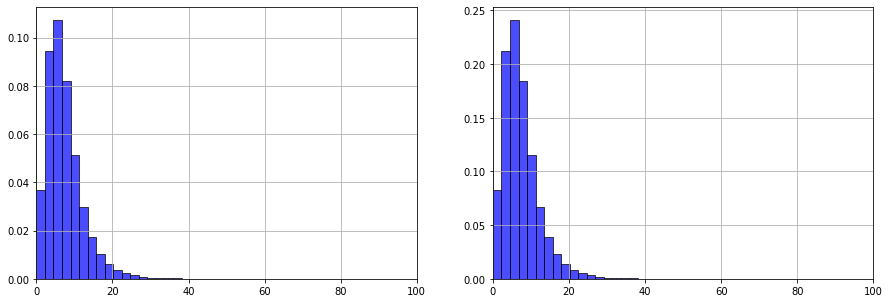

In [28]:
data = merged_nearest_distances_ctrl

# hist
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(data, bins=100, density=False, alpha=0.7, color='blue', edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)

# 手动 hist
counts, bin_edges = np.histogram(data, bins=100)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.subplot(1,2,2)
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], color='blue', alpha=0.7, edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))
# hist
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(data, bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)

# 手动 hist
counts, bin_edges = np.histogram(data, bins=100)
possibility = counts / sum(counts)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.subplot(1,2,2)
plt.bar(bin_centers, possibility, width=bin_edges[1] - bin_edges[0], color='blue', alpha=0.7, edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)
plt.show()

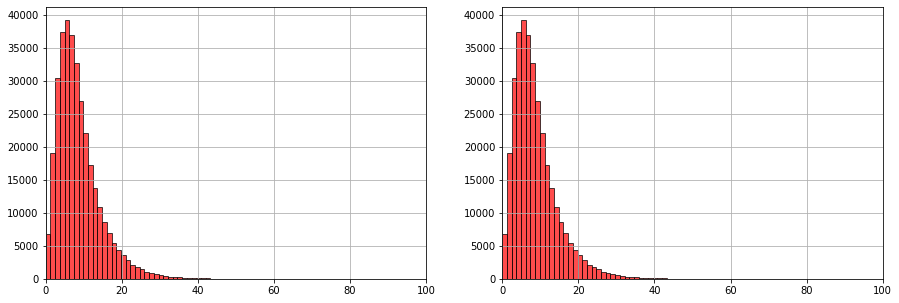

<Figure size 1080x360 with 0 Axes>

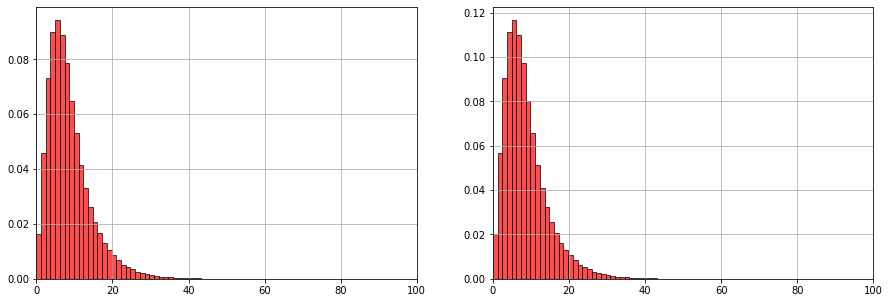

In [29]:
data = merged_nearest_distances_rett

# hist
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(data, bins=100, density=False, alpha=0.7, color='red', edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)

# 手动 hist
counts, bin_edges = np.histogram(data, bins=100)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.subplot(1,2,2)
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], color='red', alpha=0.7, edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))
# hist
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(data, bins=100, density=True, alpha=0.7, color='red', edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)

# 手动 hist
counts, bin_edges = np.histogram(data, bins=100)
possibility = counts / sum(counts)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.subplot(1,2,2)
plt.bar(bin_centers, possibility, width=bin_edges[1] - bin_edges[0], color='red', alpha=0.7, edgecolor='black')
plt.xlim(0, 100)
plt.grid(True)
plt.show()